# Chapter 2: Deep Dive into Qlib Data Module
# 第二章：Qlib数据模块深度解析

**Author**: Microsoft Qlib Team  
**License**: MIT License  
**Last Updated**: 2025-01-09

---

## 📚 Table of Contents / 目录

1. [Data Architecture Overview / 数据架构概览](#data-architecture)
2. [Raw Data Inspection / 原始数据探索](#raw-data)
3. [Data API Deep Dive / 数据API深入](#data-api)
4. [DataLoader: The Foundation / 数据加载器：基础](#dataloader)
5. [DataHandler: Processing Pipeline / 数据处理器：处理管道](#datahandler)
6. [Data Processors / 数据处理器](#processors)
7. [Dataset Construction / 数据集构建](#dataset)
8. [Time Series Dataset / 时间序列数据集](#ts-dataset)
9. [Alpha158: Production-Ready Features / Alpha158：生产级特征](#alpha158)
10. [Custom Feature Engineering / 自定义特征工程](#custom-features)
11. [Performance Optimization / 性能优化](#optimization)
12. [Common Pitfalls / 常见陷阱](#pitfalls)

## Setup and Imports / 设置和导入

In [17]:
# Essential imports / 必要导入
import qlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
import warnings
warnings.filterwarnings('ignore')

# Qlib specific imports / Qlib特定导入
from qlib.data import D
from qlib.config import C
from qlib.data.dataset.loader import QlibDataLoader
from qlib.data.dataset.handler import DataHandlerLP
from qlib.data.dataset import DatasetH, TSDatasetH
from qlib.data.dataset.processor import *

# Visualization settings / 可视化设置
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("✅ Libraries imported successfully")

✅ Libraries imported successfully


In [18]:
# Initialize Qlib / 初始化Qlib
qlib.init()

# Load configuration from previous notebook / 加载上一个notebook的配置
try:
    with open('experiment_config.json', 'r') as f:
        config = json.load(f)
    print("✅ Configuration loaded from experiment_config.json")
except FileNotFoundError:
    # Default configuration / 默认配置
    config = {
        "market": "csi300",
        "benchmark": "SH000300",
        "exp_name": "tutorial_exp",
        "train_start": "2008-01-01",
        "train_end": "2014-12-31",
        "valid_start": "2015-01-01",
        "valid_end": "2016-12-31",
        "test_start": "2017-01-01",
        "test_end": "2020-08-01"
    }
    print("⚠️ Using default configuration")

# Extract configuration / 提取配置
MARKET = config['market']
BENCHMARK = config['benchmark']
print(f"\nMarket: {MARKET}, Benchmark: {BENCHMARK}")

[19012:MainThread](2025-09-10 04:31:37,150) INFO - qlib.Initialization - [config.py:452] - default_conf: client.
[19012:MainThread](2025-09-10 04:31:37,151) INFO - qlib.Initialization - [__init__.py:75] - qlib successfully initialized based on client settings.
[19012:MainThread](2025-09-10 04:31:37,152) INFO - qlib.Initialization - [__init__.py:77] - data_path={'__DEFAULT_FREQ': WindowsPath('C:/Users/zihao/.qlib/qlib_data/cn_data')}


✅ Configuration loaded from experiment_config.json

Market: csi300, Benchmark: SH000300


## 1. Data Architecture Overview / 数据架构概览 <a id='data-architecture'></a>

### Qlib Data Pipeline / Qlib数据管道

```
┌──────────────────────────────────────────────────────────────────┐
│                        Qlib Data Pipeline                        │
├──────────────────────────────────────────────────────────────────┤
│                                                                  │
│  Raw Data          DataLoader         DataHandler      Dataset   │
│  原始数据           数据加载器          数据处理器        数据集    │
│                                                                  │
│  ┌────────┐      ┌────────────┐    ┌─────────────┐  ┌────────┐   │
│  │ Binary │  →   │   Load &   │ →  │  Process &  │ →│ Train/ │   │
│  │  Files │      │   Cache    │    │  Transform  │  │ Valid/ │   │
│  └────────┘      └────────────┘    └─────────────┘  │  Test  │   │
│                                                     └────────┘   │
│  - OHLCV         - Expression      - Normalization   - Segments  │
│  - Factor        - Features        - Fill NaN        - Iterator  │
│  - Calendar      - Labels          - Clip Outliers   - Sampler   │
│                                    - Custom Process              │
└──────────────────────────────────────────────────────────────────┘
```

## 2. Raw Data Inspection / 原始数据探索 <a id='raw-data'></a>

In [19]:
# Check data directory structure / 检查数据目录结构
data_path = Path.home() / '.qlib' / 'qlib_data' / 'cn_data'
if data_path.exists():
    print(f"Data directory: {data_path}")
    print("\nDirectory structure / 目录结构:")
    for item in sorted(data_path.iterdir())[:10]:
        if item.is_dir():
            print(f"  📁 {item.name}/")
        else:
            print(f"  📄 {item.name}")
else:
    print("❌ Data directory not found. Please download data first.")
    from qlib.tests.data import GetData
    GetData().qlib_data(exists_skip=True)

Data directory: C:\Users\zihao\.qlib\qlib_data\cn_data

Directory structure / 目录结构:
  📁 calendars/
  📁 features/
  📁 financial/
  📁 instruments/


### 2.1 Calendar Data / 交易日历数据

Trading days in 2024: 242

First trading day: 2024-01-02 00:00:00
Last trading day: 2024-12-31 00:00:00


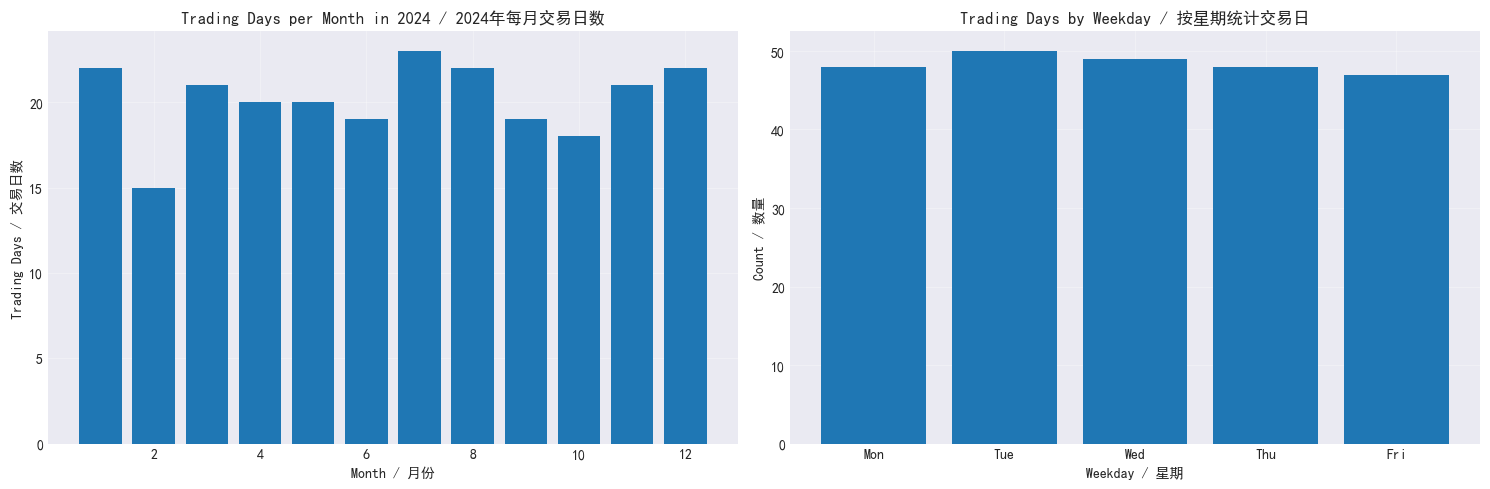

In [20]:
# Explore trading calendar / 探索交易日历
calendar = D.calendar(start_time='2024-01-01', end_time='2024-12-31', freq='day')

print(f"Trading days in 2024: {len(calendar)}")
print(f"\nFirst trading day: {calendar[0]}")
print(f"Last trading day: {calendar[-1]}")

# Configure matplotlib for Chinese display / 配置matplotlib以显示中文
plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans', 'Arial Unicode MS', 'Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# Analyze trading day distribution / 分析交易日分布
calendar_df = pd.DataFrame(calendar, columns=['date'])
calendar_df['month'] = calendar_df['date'].dt.month
calendar_df['weekday'] = calendar_df['date'].dt.dayofweek

# Trading days per month / 每月交易日数
monthly_days = calendar_df.groupby('month').size()

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Monthly distribution / 月度分布
axes[0].bar(monthly_days.index, monthly_days.values)
axes[0].set_xlabel('Month / 月份')
axes[0].set_ylabel('Trading Days / 交易日数')
axes[0].set_title('Trading Days per Month in 2024 / 2024年每月交易日数')
axes[0].grid(True, alpha=0.3)

# Weekday distribution / 星期分布
weekday_counts = calendar_df['weekday'].value_counts().sort_index()
weekdays = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri']
axes[1].bar(weekdays, weekday_counts.values)
axes[1].set_xlabel('Weekday / 星期')
axes[1].set_ylabel('Count / 数量')
axes[1].set_title('Trading Days by Weekday / 按星期统计交易日')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 2.2 Instrument Universe / 股票池

Static universe type: <class 'dict'>
Static universe expression: {'market': 'csi300', 'filter_pipe': []}

2020-01-01: 300 stocks
2021-01-01: 300 stocks
2022-01-01: 300 stocks
2023-01-01: 300 stocks
2024-01-01: 300 stocks


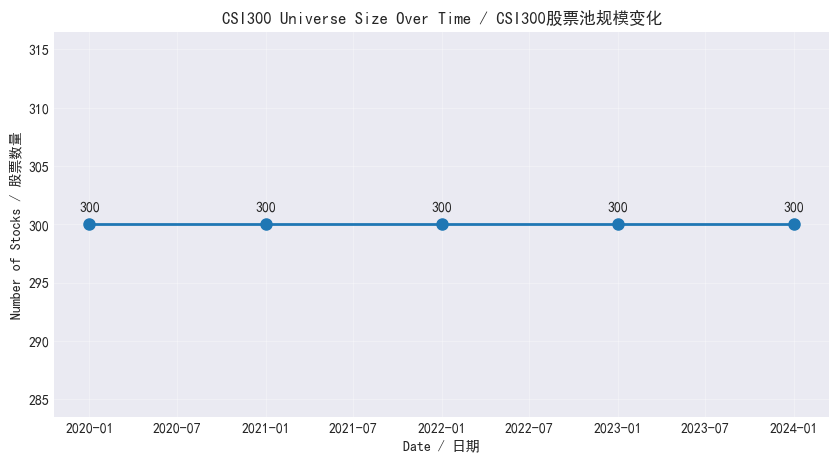

In [21]:
# Static vs Dynamic Universe comparison / 静态vs动态股票池对比

# Static universe / 静态股票池
static_universe = D.instruments(MARKET)
print(f"Static universe type: {type(static_universe)}")
print(f"Static universe expression: {static_universe}\n")

# Dynamic universe over time / 动态股票池随时间变化
dates = pd.date_range('2020-01-01', '2024-01-01', freq='YS')
universe_sizes = []

for date in dates:
    date_str = date.strftime('%Y-%m-%d')
    universe = D.list_instruments(
        D.instruments(MARKET),
        start_time=date_str,
        end_time=date_str
    )
    universe_sizes.append(len(universe))
    print(f"{date_str}: {len(universe)} stocks")

# Visualize universe changes / 可视化股票池变化
plt.figure(figsize=(10, 5))
plt.plot(dates, universe_sizes, marker='o', linewidth=2, markersize=8)
plt.xlabel('Date / 日期')
plt.ylabel('Number of Stocks / 股票数量')
plt.title(f'{MARKET.upper()} Universe Size Over Time / {MARKET.upper()}股票池规模变化')
plt.grid(True, alpha=0.3)
for i, (date, size) in enumerate(zip(dates, universe_sizes)):
    plt.annotate(str(size), (date, size), textcoords="offset points", 
                xytext=(0,10), ha='center')
plt.show()

### 2.3 Basic OHLCV Data / 基础OHLCV数据

In [22]:
# Get sample stock data / 获取样例股票数据
sample_stocks = ['SH600519', 'SH600000', 'SZ000002']  # 贵州茅台, 浦发银行, 万科A
fields = ['$open', '$high', '$low', '$close', '$volume', '$factor']

raw_data = D.features(
    instruments=sample_stocks,
    fields=fields,
    start_time='2024-01-01',
    end_time='2024-01-31'
)

print("Raw OHLCV Data Sample / 原始OHLCV数据样例:")
print(raw_data.head(10))
print(f"\nData shape: {raw_data.shape}")
print(f"Data types:\n{raw_data.dtypes}")

Raw OHLCV Data Sample / 原始OHLCV数据样例:
                          $open     $high      $low    $close        $volume  \
instrument datetime                                                            
SH600000   2024-01-02  9.608777  9.637763  9.565298  9.565298  152258.937500   
           2024-01-03  9.550671  9.637627  9.550671  9.623135  125605.921875   
           2024-01-04  9.623202  9.666680  9.492767  9.594216  199312.968750   
           2024-01-05  9.565030  9.796910  9.550538  9.680970  306513.562500   
           2024-01-08  9.680803  9.724279  9.506896  9.550373  258899.593750   
           2024-01-09  9.564799  9.622767  9.477846  9.579291  212128.375000   
           2024-01-10  9.579425  9.608409  9.521455  9.521455  153467.109375   
           2024-01-11  9.507097  9.550574  9.449127  9.463619  247815.375000   
           2024-01-12  9.449696  9.507669  9.420709  9.420709  238895.343750   
           2024-01-15  9.420209  9.478179  9.376731  9.434702  197991.375000   

  

### 2.4 Price Adjustment / 价格复权

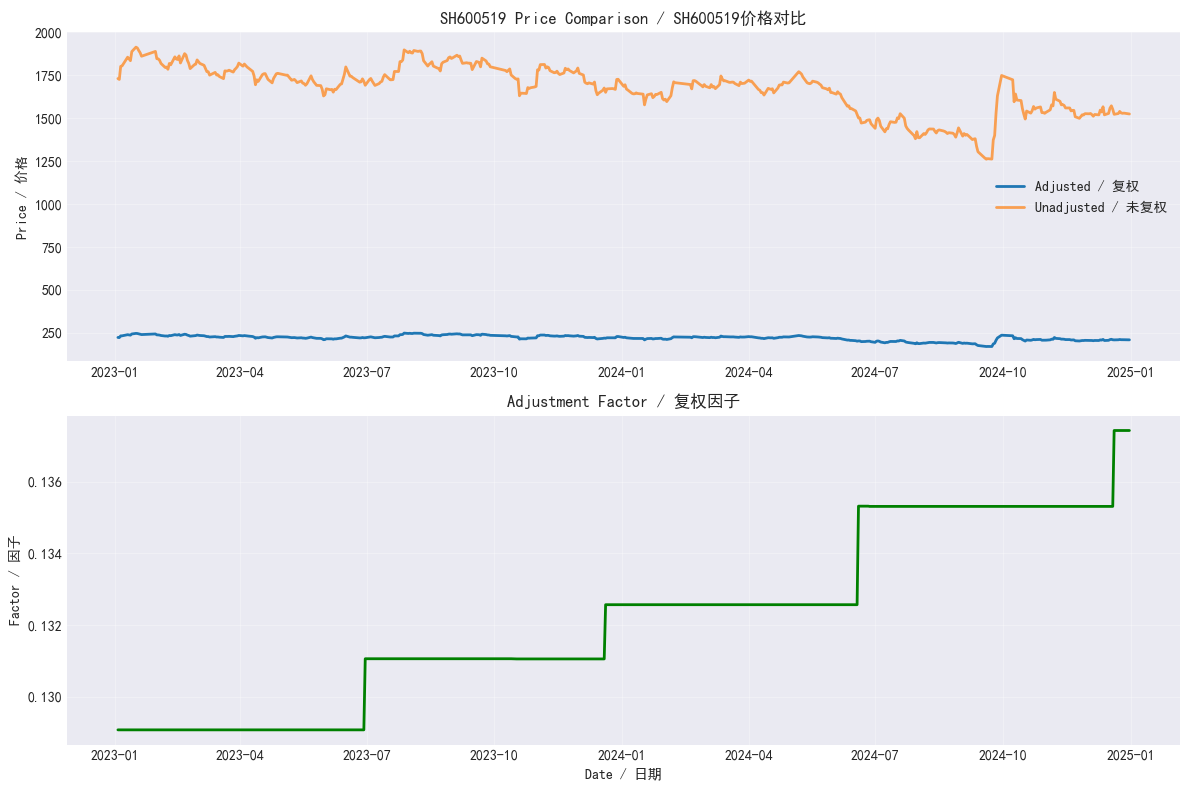

Factor range: 0.1291 - 0.1374
Factor changes indicate: stock splits, dividends, etc. / 因子变化表示：股票分割、分红等


In [23]:
# Demonstrate price adjustment / 演示价格复权
stock = 'SH600519'  # 贵州茅台
adj_data = D.features(
    instruments=[stock],
    fields=['$close', '$factor'],
    start_time='2023-01-01',
    end_time='2024-12-31'
)

# Calculate adjusted and unadjusted prices / 计算复权和未复权价格
adj_data['adjusted_close'] = adj_data['$close']
adj_data['unadjusted_close'] = adj_data['$close'] / adj_data['$factor']

# Visualize the difference / 可视化差异
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Plot prices / 绘制价格
axes[0].plot(adj_data.index.get_level_values('datetime'), 
            adj_data['adjusted_close'], label='Adjusted / 复权', linewidth=2)
axes[0].plot(adj_data.index.get_level_values('datetime'), 
            adj_data['unadjusted_close'], label='Unadjusted / 未复权', linewidth=2, alpha=0.7)
axes[0].set_ylabel('Price / 价格')
axes[0].set_title(f'{stock} Price Comparison / {stock}价格对比')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot adjustment factor / 绘制复权因子
axes[1].plot(adj_data.index.get_level_values('datetime'), 
            adj_data['$factor'], color='green', linewidth=2)
axes[1].set_ylabel('Factor / 因子')
axes[1].set_xlabel('Date / 日期')
axes[1].set_title('Adjustment Factor / 复权因子')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Factor range: {adj_data['$factor'].min():.4f} - {adj_data['$factor'].max():.4f}")
print(f"Factor changes indicate: stock splits, dividends, etc. / 因子变化表示：股票分割、分红等")

## 3. Data API Deep Dive / 数据API深入 <a id='data-api'></a>

### 3.1 Expression Engine / 表达式引擎

In [24]:
# Comprehensive expression examples / 综合表达式示例

expressions = {
    # Basic operations / 基础运算
    "Daily Return": "$close / Ref($close, 1) - 1",
    "Intraday Range": "($high - $low) / $close",
    
    # Moving averages / 移动平均
    "MA5": "Mean($close, 5)",
    "MA20": "Mean($close, 20)",
    "MA_Ratio": "Mean($close, 5) / Mean($close, 20)",
    
    # Volatility / 波动率
    "Volatility20": "Std($close/Ref($close,1)-1, 20)",
    "Volatility60": "Std($close/Ref($close,1)-1, 60)",
    
    # Volume indicators / 成交量指标
    "Volume_MA5": "Mean($volume, 5)",
    "Volume_Ratio": "$volume / Mean($volume, 20)",
    "VWAP": "Sum($close*$volume, 20) / Sum($volume, 20)",
    
    # Technical indicators / 技术指标
    "RSI": "RSI($close, 14)",
    "MACD_DIF": "EMA($close, 12) - EMA($close, 26)",
    "MACD_Signal": "EMA(EMA($close, 12) - EMA($close, 26), 9)",
    
    # Price position / 价格位置
    "Price_Position": "($close - Min($low, 20)) / (Max($high, 20) - Min($low, 20))",
    
    # Correlation and beta / 相关性和贝塔
    "Correlation20": "Corr($close/Ref($close,1), Mean($close/Ref($close,1), 20), 20)",
}

# Calculate all expressions / 计算所有表达式
test_stock = 'SH600519'
expr_results = {}

for name, expr in expressions.items():
    try:
        result = D.features(
            instruments=[test_stock],
            fields=[expr],
            start_time='2024-01-01',
            end_time='2024-01-31'
        )
        expr_results[name] = result
        print(f"✅ {name}: Calculated successfully")
    except Exception as e:
        print(f"❌ {name}: {str(e)[:50]}...")

# Display sample results / 显示样例结果
if expr_results:
    sample_df = pd.concat(
        [df.iloc[-5:] for df in list(expr_results.values())[:5]], 
        axis=1
    )
    sample_df.columns = list(expr_results.keys())[:5]
    print("\nSample calculated features / 样例计算特征:")
    print(sample_df)

✅ Daily Return: Calculated successfully
✅ Intraday Range: Calculated successfully
✅ MA5: Calculated successfully
✅ MA20: Calculated successfully
✅ MA_Ratio: Calculated successfully
✅ Volatility20: Calculated successfully
✅ Volatility60: Calculated successfully
✅ Volume_MA5: Calculated successfully
✅ Volume_Ratio: Calculated successfully
✅ VWAP: Calculated successfully
❌ RSI: The operator [RSI] is not registered...
✅ MACD_DIF: Calculated successfully
✅ MACD_Signal: Calculated successfully
✅ Price_Position: Calculated successfully
✅ Correlation20: Calculated successfully

Sample calculated features / 样例计算特征:
                       Daily Return  Intraday Range         MA5        MA20  \
instrument datetime                                                           
SH600519   2024-01-25      0.007380        0.011599  216.352524  218.777039   
           2024-01-26     -0.000416        0.012887  216.414032  218.195923   
           2024-01-29      0.007744        0.012297  216.626114  217.6

### 3.2 Advanced Expressions / 高级表达式

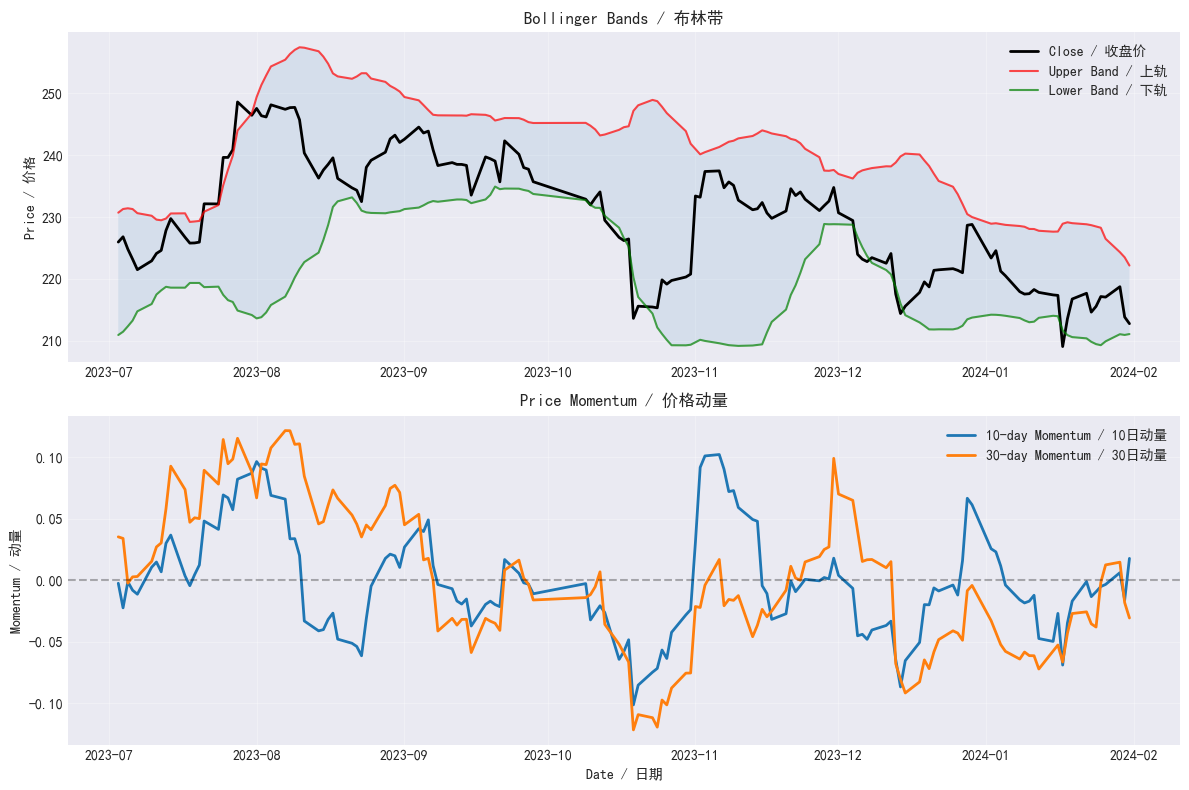

In [25]:
# Complex expression combinations / 复杂表达式组合

advanced_expressions = [
    # Bollinger Bands / 布林带
    ("BB_Upper", "Mean($close, 20) + 2*Std($close, 20)"),
    ("BB_Lower", "Mean($close, 20) - 2*Std($close, 20)"),
    ("BB_Width", "(Mean($close, 20) + 2*Std($close, 20) - (Mean($close, 20) - 2*Std($close, 20))) / Mean($close, 20)"),
    
    # Momentum / 动量
    ("Momentum_10", "$close / Ref($close, 10) - 1"),
    ("Momentum_30", "$close / Ref($close, 30) - 1"),
    
    # Relative strength / 相对强度
    ("RS_5_20", "Mean($close/Ref($close,1)-1, 5) / Mean($close/Ref($close,1)-1, 20)"),
]

# Calculate and visualize / 计算并可视化
adv_data = D.features(
    instruments=['SH600519'],
    fields=['$close'] + [expr for _, expr in advanced_expressions],
    start_time='2023-07-01',
    end_time='2024-01-31'
)

# Rename columns / 重命名列
adv_data.columns = ['Close'] + [name for name, _ in advanced_expressions]

# Visualize Bollinger Bands / 可视化布林带
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

dates = adv_data.index.get_level_values('datetime')

# Price with Bollinger Bands / 价格与布林带
axes[0].plot(dates, adv_data['Close'], label='Close / 收盘价', color='black', linewidth=2)
axes[0].plot(dates, adv_data['BB_Upper'], label='Upper Band / 上轨', color='red', alpha=0.7)
axes[0].plot(dates, adv_data['BB_Lower'], label='Lower Band / 下轨', color='green', alpha=0.7)
axes[0].fill_between(dates, adv_data['BB_Upper'], adv_data['BB_Lower'], alpha=0.1)
axes[0].set_ylabel('Price / 价格')
axes[0].set_title('Bollinger Bands / 布林带')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Momentum indicators / 动量指标
axes[1].plot(dates, adv_data['Momentum_10'], label='10-day Momentum / 10日动量', linewidth=2)
axes[1].plot(dates, adv_data['Momentum_30'], label='30-day Momentum / 30日动量', linewidth=2)
axes[1].axhline(y=0, color='black', linestyle='--', alpha=0.3)
axes[1].set_ylabel('Momentum / 动量')
axes[1].set_xlabel('Date / 日期')
axes[1].set_title('Price Momentum / 价格动量')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. DataLoader: The Foundation / 数据加载器：基础 <a id='dataloader'></a>

In [26]:
# Basic DataLoader usage / 基础DataLoader使用
from qlib.data.dataset.loader import QlibDataLoader

# Create a simple DataLoader / 创建简单的DataLoader
simple_loader = QlibDataLoader(
    config=(
        ["$close", "$volume", "$close/Ref($close,1)-1"],  # Features / 特征
        ["CLOSE", "VOLUME", "RETURN"]  # Names / 名称
    )
)

# Load data / 加载数据
simple_data = simple_loader.load(
    instruments=['SH600519', 'SH600000'],
    start_time='2024-01-01',
    end_time='2024-01-31'
)

print("Simple DataLoader Output / 简单DataLoader输出:")
print(simple_data.head(10))
print(f"\nData statistics / 数据统计:")
print(simple_data.describe())

Simple DataLoader Output / 简单DataLoader输出:
                            CLOSE         VOLUME    RETURN
datetime   instrument                                     
2024-01-02 SH600000      9.565298  152258.937500 -0.003014
           SH600519    223.379959  242563.937500 -0.023748
2024-01-03 SH600000      9.623135  125605.921875  0.006047
           SH600519    224.571793  152594.484375  0.005335
2024-01-04 SH600000      9.594216  199312.968750 -0.003005
           SH600519    221.257462  162565.078125 -0.014758
2024-01-05 SH600000      9.680970  306513.562500  0.009042
           SH600519    220.509872  152696.859375 -0.003379
2024-01-08 SH600000      9.550373  258899.593750 -0.013490
           SH600519    217.941956  193001.515625 -0.011645

Data statistics / 数据统计:
            CLOSE         VOLUME     RETURN
count   44.000000      44.000000  44.000000
mean   113.463127  262145.125000  -0.000883
std    105.057083  106920.906250   0.011081
min      9.420709   87526.125000  -0.038080
25% 

In [27]:
# Advanced DataLoader with multiple feature sets / 高级DataLoader with多特征集

# Define comprehensive features / 定义综合特征
price_features = [
    "$open", "$high", "$low", "$close"
]

volume_features = [
    "$volume",
    "$volume/Mean($volume, 5)",
    "$volume/Mean($volume, 20)"
]

technical_features = [
    "$close/Ref($close, 1) - 1",  # Daily return
    "($high-$low)/$close",        # Daily range
    "Mean($close, 5)",            # MA5
    "Mean($close, 20)",           # MA20
    "Std($close/Ref($close,1)-1, 20)",  # Volatility
]

# Combine all features / 组合所有特征
all_features = price_features + volume_features + technical_features
feature_names = [
    "open", "high", "low", "close",
    "volume", "volume_ratio_5", "volume_ratio_20",
    "return", "range", "ma5", "ma20", "volatility"
]

# Create comprehensive DataLoader / 创建综合DataLoader
comprehensive_loader = QlibDataLoader(
    config=(all_features, feature_names)
)

# Load data for multiple stocks / 为多只股票加载数据
comprehensive_data = comprehensive_loader.load(
    instruments=D.instruments('csi300'),
    start_time='2024-01-01',
    end_time='2024-01-31'
)

print(f"Comprehensive data shape: {comprehensive_data.shape}")
print(f"\nFeature columns: {list(comprehensive_data.columns)}")
print(f"\nSample data:")
print(comprehensive_data.head())

Comprehensive data shape: (6600, 12)

Feature columns: ['open', 'high', 'low', 'close', 'volume', 'volume_ratio_5', 'volume_ratio_20', 'return', 'range', 'ma5', 'ma20', 'volatility']

Sample data:
                           open      high       low     close        volume  \
datetime   instrument                                                         
2024-01-02 SH600000    9.608777  9.637763  9.565298  9.565298  1.522589e+05   
           SH600009    3.204804  3.209668  3.124051  3.130862  8.064436e+05   
           SH600010    2.666955  2.666955  2.630670  2.630670  7.685691e+05   
           SH600011    2.559533  2.686507  2.559533  2.673141  2.112991e+06   
           SH600015    5.949242  6.065479  5.938674  6.023211  5.194351e+05   

                       volume_ratio_5  volume_ratio_20    return     range  \
datetime   instrument                                                        
2024-01-02 SH600000          0.911627         0.850484 -0.003014  0.007576   
           SH60

## 5. DataHandler: Processing Pipeline / 数据处理器：处理管道 <a id='datahandler'></a>

In [28]:
# Create DataHandler with processing pipeline / 创建带处理管道的DataHandler
from qlib.data.dataset.handler import DataHandlerLP
from qlib.data.dataset.processor import Fillna, ZScoreNorm, CSZScoreNorm, RobustZScoreNorm

# Define feature and label configurations / 定义特征和标签配置
feature_config = {
    "klass": "QlibDataLoader",
    "kwargs": {
        "config": (
            [
                "$close/Ref($close,1)-1",
                "($high-$low)/$close",
                "$volume/Mean($volume,20)",
                "Mean($close,5)/Mean($close,20)",
                "Std($close/Ref($close,1)-1,20)",
                "Corr($close,$volume,20)",
                "($close-Min($low,20))/(Max($high,20)-Min($low,20))",
            ],
            ["RETURN", "RANGE", "VOLUME_RATIO", "MA_RATIO", "VOLATILITY", "CORR_CV", "POSITION"]
        )
    }
}

label_config = {
    "klass": "QlibDataLoader",
    "kwargs": {
        "config": (
            ["Ref($close,-5)/$close-1"],  # 5-day future return
            ["LABEL"]
        )
    }
}

# Create DataHandler / 创建DataHandler
handler = DataHandlerLP(
    instruments=D.instruments('csi300')[:50],  # Use 50 stocks for demo
    start_time='2020-01-01',
    end_time='2024-01-31',
    data_loader=feature_config,
    label=label_config,
    infer_processors=[
        Fillna(fill_value=0),
        ZScoreNorm(fit_start_time='2020-01-01', fit_end_time='2022-12-31')
    ],
    learn_processors=[
        Fillna(fill_value=0),
        CSZScoreNorm(fit_start_time='2020-01-01', fit_end_time='2022-12-31')
    ]
)

print("DataHandler created successfully!")
print(f"Instruments: {len(handler.instruments)} stocks")
print(f"Time range: {handler.start_time} to {handler.end_time}")

KeyError: slice(None, 50, None)

In [ ]:
# Fetch and analyze processed data / 获取并分析处理后的数据
processed_data = handler.fetch()

print(f"Processed data shape: {processed_data.shape}")
print(f"\nData info:")
print(processed_data.info())

# Check for missing values / 检查缺失值
print(f"\nMissing values per column / 每列缺失值:")
print(processed_data.isnull().sum())

# Statistical summary / 统计摘要
print(f"\nStatistical summary / 统计摘要:")
print(processed_data.describe())

## 6. Data Processors / 数据处理器 <a id='processors'></a>

In [ ]:
# Demonstrate different processors / 演示不同的处理器
from qlib.data.dataset.processor import *

# Create sample data with issues / 创建有问题的样例数据
np.random.seed(42)
sample_size = 1000
dates = pd.date_range('2023-01-01', periods=sample_size, freq='D')

# Create data with outliers and missing values / 创建带异常值和缺失值的数据
sample_df = pd.DataFrame({
    'feature1': np.random.randn(sample_size) * 2 + 10,
    'feature2': np.random.randn(sample_size) * 5 + 50,
    'feature3': np.random.randn(sample_size) * 1 + 5,
}, index=pd.MultiIndex.from_product([dates, ['STOCK_A']], names=['datetime', 'instrument']))

# Add outliers / 添加异常值
outlier_indices = np.random.choice(sample_size, 50, replace=False)
sample_df.iloc[outlier_indices, 0] *= 10

# Add missing values / 添加缺失值
missing_indices = np.random.choice(sample_size, 100, replace=False)
sample_df.iloc[missing_indices, 1] = np.nan

print("Original data statistics / 原始数据统计:")
print(sample_df.describe())
print(f"\nMissing values: {sample_df.isnull().sum().to_dict()}")

In [ ]:
# Apply different processors / 应用不同的处理器

# 1. Fillna processor / 填充缺失值处理器
fillna_proc = Fillna(fill_value=0)
df_filled = fillna_proc(sample_df.copy())

# 2. ZScore normalization / Z分数标准化
zscore_proc = ZScoreNorm()
zscore_proc.fit(df_filled)
df_zscore = zscore_proc(df_filled.copy())

# 3. Robust ZScore (resistant to outliers) / 稳健Z分数（抗异常值）
robust_proc = RobustZScoreNorm()
robust_proc.fit(df_filled)
df_robust = robust_proc(df_filled.copy())

# 4. MinMax normalization / 最小最大标准化
minmax_proc = MinMaxNorm()
minmax_proc.fit(df_filled)
df_minmax = minmax_proc(df_filled.copy())

# Visualize the effects / 可视化效果
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# Original distribution / 原始分布
axes[0, 0].hist(sample_df['feature1'].dropna(), bins=50, alpha=0.7, color='blue')
axes[0, 0].set_title('Original (with outliers) / 原始（带异常值）')
axes[0, 0].set_ylabel('Frequency / 频率')

# After fillna / 填充缺失值后
axes[0, 1].hist(df_filled['feature2'], bins=50, alpha=0.7, color='green')
axes[0, 1].set_title('After Fillna / 填充缺失值后')

# After ZScore / Z分数标准化后
axes[0, 2].hist(df_zscore['feature1'], bins=50, alpha=0.7, color='orange')
axes[0, 2].set_title('ZScore Normalized / Z分数标准化')

# After Robust ZScore / 稳健Z分数后
axes[1, 0].hist(df_robust['feature1'], bins=50, alpha=0.7, color='red')
axes[1, 0].set_title('Robust ZScore / 稳健Z分数')
axes[1, 0].set_ylabel('Frequency / 频率')

# After MinMax / 最小最大标准化后
axes[1, 1].hist(df_minmax['feature1'], bins=50, alpha=0.7, color='purple')
axes[1, 1].set_title('MinMax Normalized / 最小最大标准化')

# Comparison boxplot / 对比箱线图
comparison_data = pd.DataFrame({
    'Original': sample_df['feature1'].dropna()[:200],
    'ZScore': df_zscore['feature1'][:200],
    'Robust': df_robust['feature1'][:200],
    'MinMax': df_minmax['feature1'][:200]
})
axes[1, 2].boxplot(comparison_data.values, labels=comparison_data.columns)
axes[1, 2].set_title('Comparison / 对比')
axes[1, 2].set_ylabel('Value / 值')

plt.tight_layout()
plt.show()

print("\nProcessed data statistics / 处理后数据统计:")
print(f"ZScore - mean: {df_zscore['feature1'].mean():.4f}, std: {df_zscore['feature1'].std():.4f}")
print(f"Robust - mean: {df_robust['feature1'].mean():.4f}, std: {df_robust['feature1'].std():.4f}")
print(f"MinMax - min: {df_minmax['feature1'].min():.4f}, max: {df_minmax['feature1'].max():.4f}")

## 7. Dataset Construction / 数据集构建 <a id='dataset'></a>

In [ ]:
# Create dataset with train/valid/test splits / 创建训练/验证/测试分割的数据集
from qlib.data.dataset import DatasetH

# Use the handler we created earlier / 使用之前创建的handler
dataset = DatasetH(
    handler,
    segments={
        'train': ('2020-01-01', '2022-12-31'),
        'valid': ('2023-01-01', '2023-06-30'),
        'test': ('2023-07-01', '2024-01-31')
    }
)

print("Dataset segments / 数据集分段:")
for segment in ['train', 'valid', 'test']:
    data = dataset.prepare(segment)
    print(f"\n{segment.upper()} segment:")
    print(f"  Shape: {data.shape}")
    print(f"  Date range: {data.index.get_level_values('datetime').min()} to {data.index.get_level_values('datetime').max()}")
    print(f"  Unique stocks: {data.index.get_level_values('instrument').nunique()}")
    print(f"  Features: {list(data.columns)}")

In [ ]:
# Analyze dataset statistics / 分析数据集统计

# Get data for each segment / 获取每个分段的数据
train_data = dataset.prepare('train')
valid_data = dataset.prepare('valid')
test_data = dataset.prepare('test')

# Create comparison / 创建对比
comparison_stats = pd.DataFrame({
    'Train': train_data.describe().loc['mean'],
    'Valid': valid_data.describe().loc['mean'],
    'Test': test_data.describe().loc['mean']
}).T

print("Mean values across segments / 各分段平均值:")
print(comparison_stats)

# Visualize feature distributions across segments / 可视化各分段特征分布
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i, col in enumerate(train_data.columns[:8]):
    axes[i].hist(train_data[col].dropna(), bins=30, alpha=0.5, label='Train', density=True)
    axes[i].hist(valid_data[col].dropna(), bins=30, alpha=0.5, label='Valid', density=True)
    axes[i].hist(test_data[col].dropna(), bins=30, alpha=0.5, label='Test', density=True)
    axes[i].set_title(f'{col} Distribution')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Time Series Dataset / 时间序列数据集 <a id='ts-dataset'></a>

In [ ]:
# Create time series dataset / 创建时间序列数据集
from qlib.data.dataset import TSDatasetH

# Time series parameters / 时间序列参数
step_len = 20  # Look-back window / 回望窗口

ts_dataset = TSDatasetH(
    handler=handler,
    segments={
        'train': ('2020-01-01', '2022-12-31'),
        'valid': ('2023-01-01', '2023-06-30'),
        'test': ('2023-07-01', '2024-01-31')
    },
    step_len=step_len
)

# Prepare data sampler / 准备数据采样器
train_sampler = ts_dataset.prepare('train')
print(f"Time series dataset created")
print(f"Step length (look-back window): {step_len}")
print(f"Number of samples in train: {len(train_sampler)}")

In [ ]:
# Examine time series samples / 检查时间序列样本

# Get a few samples / 获取几个样本
sample_indices = [0, 100, 500, 1000]
samples = []

for idx in sample_indices:
    if idx < len(train_sampler):
        sample = train_sampler[idx]
        samples.append(sample)
        print(f"Sample {idx} shape: {sample.shape}")

# Visualize a time series sample / 可视化时间序列样本
if samples:
    sample_to_plot = samples[-1]  # Last valid sample
    
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()
    
    for i in range(min(8, sample_to_plot.shape[1])):
        axes[i].plot(sample_to_plot[:, i], marker='o', markersize=4)
        axes[i].set_title(f'Feature {i}')
        axes[i].set_xlabel('Time Step')
        axes[i].set_ylabel('Value')
        axes[i].grid(True, alpha=0.3)
    
    plt.suptitle(f'Time Series Sample (Window={step_len})', fontsize=14)
    plt.tight_layout()
    plt.show()

# Check for NaN handling in time series / 检查时间序列中的NaN处理
nan_counts = []
for i in range(min(100, len(train_sampler))):
    sample = train_sampler[i]
    nan_count = np.isnan(sample).sum()
    nan_counts.append(nan_count)

print(f"\nNaN statistics in first 100 samples:")
print(f"  Samples with NaN: {sum(1 for x in nan_counts if x > 0)}")
print(f"  Average NaN per sample: {np.mean(nan_counts):.2f}")
print(f"  Max NaN in a sample: {max(nan_counts)}")

## 9. Alpha158: Production-Ready Features / Alpha158：生产级特征 <a id='alpha158'></a>

In [ ]:
# Load Alpha158 feature set / 加载Alpha158特征集
from qlib.contrib.data.handler import Alpha158

# Create Alpha158 handler / 创建Alpha158处理器
alpha158_handler = Alpha158(
    instruments=D.instruments('csi300')[:30],  # Use 30 stocks for demo
    start_time='2020-01-01',
    end_time='2024-01-31',
    fit_start_time='2020-01-01',
    fit_end_time='2022-12-31',
    infer_processors=[],  # Use default processors
)

print("Alpha158 handler created")
print(f"Number of features: {len(alpha158_handler.data_loader.fields)}")
print(f"\nFirst 20 features:")
for i, (expr, name) in enumerate(alpha158_handler.data_loader.fields[:20]):
    print(f"  {i+1}. {name}: {expr[:50]}..." if len(expr) > 50 else f"  {i+1}. {name}: {expr}")

In [ ]:
# Analyze Alpha158 features / 分析Alpha158特征

# Fetch data / 获取数据
alpha158_data = alpha158_handler.fetch()

print(f"Alpha158 data shape: {alpha158_data.shape}")
print(f"Memory usage: {alpha158_data.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Feature categories in Alpha158 / Alpha158中的特征类别
feature_categories = {
    'KMID': 'Price relative position',
    'KUP': 'Upper shadow ratio',
    'KLOW': 'Lower shadow ratio',
    'KSFT': 'Body position',
    'OPEN': 'Open price features',
    'HIGH': 'High price features',
    'LOW': 'Low price features',
    'CLOSE': 'Close price features',
    'VOLUME': 'Volume features',
    'ROC': 'Rate of change',
    'MA': 'Moving average',
    'STD': 'Standard deviation',
    'BETA': 'Market beta',
    'RSI': 'Relative strength index',
    'PSY': 'Psychological line',
    'BIAS': 'Bias rate',
    'LABEL': 'Target label'
}

# Count features by category / 按类别统计特征
category_counts = {}
for col in alpha158_data.columns:
    for prefix, category in feature_categories.items():
        if col.startswith(prefix):
            category_counts[category] = category_counts.get(category, 0) + 1
            break
    else:
        category_counts['Other'] = category_counts.get('Other', 0) + 1

# Visualize feature categories / 可视化特征类别
if category_counts:
    plt.figure(figsize=(10, 6))
    categories = list(category_counts.keys())
    counts = list(category_counts.values())
    plt.barh(categories, counts, color='steelblue')
    plt.xlabel('Number of Features / 特征数量')
    plt.title('Alpha158 Feature Categories / Alpha158特征类别')
    plt.grid(True, alpha=0.3)
    for i, v in enumerate(counts):
        plt.text(v + 0.5, i, str(v), va='center')
    plt.tight_layout()
    plt.show()

## 10. Custom Feature Engineering / 自定义特征工程 <a id='custom-features'></a>

In [ ]:
# Create custom feature set / 创建自定义特征集

class CustomFeatureEngineering:
    """Custom feature engineering for quantitative trading / 量化交易的自定义特征工程"""
    
    @staticmethod
    def get_price_features():
        """Price-based features / 基于价格的特征"""
        return [
            # Trend indicators / 趋势指标
            ("Ref($close, 1) / Ref($close, 5)", "PRICE_MOMENTUM_5D"),
            ("Ref($close, 5) / Ref($close, 20)", "PRICE_MOMENTUM_20D"),
            
            # Price efficiency / 价格效率
            ("$close / ((Max($high, 20) + Min($low, 20)) / 2)", "PRICE_EFFICIENCY"),
            
            # Support and resistance / 支撑和阻力
            ("($close - Min($low, 20)) / (Max($high, 20) - Min($low, 20))", "PRICE_POSITION"),
            
            # Gap indicators / 跳空指标
            ("$open / Ref($close, 1) - 1", "OVERNIGHT_GAP"),
        ]
    
    @staticmethod
    def get_volume_features():
        """Volume-based features / 基于成交量的特征"""
        return [
            # Volume trends / 成交量趋势
            ("Mean($volume, 5) / Mean($volume, 20)", "VOLUME_TREND"),
            
            # Volume-price correlation / 量价相关性
            ("Corr($close, $volume, 20)", "PRICE_VOLUME_CORR"),
            
            # Accumulation/Distribution / 累积/派发
            ("Sum($volume * ($close - Ref($close, 1)) / Ref($close, 1), 20)", "ACCUMULATION"),
            
            # Volume spike / 成交量激增
            ("$volume / Mean($volume, 60)", "VOLUME_SPIKE"),
        ]
    
    @staticmethod
    def get_volatility_features():
        """Volatility-based features / 基于波动率的特征"""
        return [
            # Historical volatility / 历史波动率
            ("Std($close/Ref($close,1)-1, 20)", "VOLATILITY_20D"),
            ("Std($close/Ref($close,1)-1, 60)", "VOLATILITY_60D"),
            
            # Volatility ratio / 波动率比率
            ("Std($close/Ref($close,1)-1, 20) / Std($close/Ref($close,1)-1, 60)", "VOLATILITY_RATIO"),
            
            # Parkinson volatility / 帕金森波动率
            ("Std(Log($high/$low), 20)", "PARKINSON_VOLATILITY"),
        ]
    
    @staticmethod
    def get_market_microstructure_features():
        """Market microstructure features / 市场微观结构特征"""
        return [
            # Amihud illiquidity / Amihud非流动性
            ("Mean(Abs($close/Ref($close,1)-1)/$volume, 20)", "AMIHUD_ILLIQUIDITY"),
            
            # Spread proxy / 价差代理
            ("($high - $low) / (($high + $low) / 2)", "SPREAD_PROXY"),
            
            # Trading intensity / 交易强度
            ("$volume / Mean($volume, 250)", "TRADING_INTENSITY"),
        ]

# Combine all custom features / 组合所有自定义特征
custom_eng = CustomFeatureEngineering()
custom_features = (
    custom_eng.get_price_features() +
    custom_eng.get_volume_features() +
    custom_eng.get_volatility_features() +
    custom_eng.get_market_microstructure_features()
)

print(f"Total custom features: {len(custom_features)}")
print("\nCustom feature list / 自定义特征列表:")
for i, (expr, name) in enumerate(custom_features, 1):
    print(f"  {i}. {name}")

In [ ]:
# Create DataLoader with custom features / 创建带自定义特征的DataLoader
custom_expressions = [expr for expr, _ in custom_features]
custom_names = [name for _, name in custom_features]

custom_loader = QlibDataLoader(
    config=(custom_expressions, custom_names)
)

# Create handler with custom features / 创建带自定义特征的处理器
custom_handler = DataHandlerLP(
    instruments=D.instruments('csi300')[:20],  # Use 20 stocks for demo
    start_time='2023-01-01',
    end_time='2024-01-31',
    data_loader={
        "klass": "QlibDataLoader",
        "kwargs": {"config": (custom_expressions, custom_names)}
    },
    infer_processors=[
        Fillna(fill_value=0),
        ZScoreNorm(fit_start_time='2023-01-01', fit_end_time='2023-12-31')
    ]
)

# Fetch custom features / 获取自定义特征
custom_data = custom_handler.fetch()
print(f"\nCustom features data shape: {custom_data.shape}")
print(f"\nSample custom features:")
print(custom_data.head())

## 11. Performance Optimization / 性能优化 <a id='optimization'></a>

In [ ]:
# Performance comparison / 性能对比
import time

# Test different data loading strategies / 测试不同的数据加载策略

# Strategy 1: Load all at once / 策略1：一次性加载所有
start_time = time.time()
all_instruments = D.instruments('csi300')
data_all = D.features(
    instruments=all_instruments,
    fields=['$close', '$volume'],
    start_time='2023-01-01',
    end_time='2023-12-31'
)
time_all = time.time() - start_time

# Strategy 2: Load in batches / 策略2：分批加载
start_time = time.time()
batch_size = 50
data_batches = []
for i in range(0, len(all_instruments), batch_size):
    batch = all_instruments[i:i+batch_size]
    batch_data = D.features(
        instruments=batch,
        fields=['$close', '$volume'],
        start_time='2023-01-01',
        end_time='2023-12-31'
    )
    data_batches.append(batch_data)
data_batch = pd.concat(data_batches)
time_batch = time.time() - start_time

print("Performance Comparison / 性能对比:")
print(f"\nStrategy 1 (All at once):")
print(f"  Time: {time_all:.2f} seconds")
print(f"  Data shape: {data_all.shape}")
print(f"  Memory: {data_all.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

print(f"\nStrategy 2 (Batch loading):")
print(f"  Time: {time_batch:.2f} seconds")
print(f"  Data shape: {data_batch.shape}")
print(f"  Memory: {data_batch.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

print(f"\nSpeedup: {time_all/time_batch:.2f}x")

## 12. Common Pitfalls and Solutions / 常见陷阱和解决方案 <a id='pitfalls'></a>

In [ ]:
# Common pitfall examples / 常见陷阱示例

print("Common Pitfalls in Qlib Data Module / Qlib数据模块常见陷阱:\n")

# Pitfall 1: Look-ahead bias / 陷阱1：未来函数
print("1. Look-ahead Bias / 未来函数:")
print("   ❌ Wrong: Using future data in features")
print("      Example: $close/Ref($close, -1) - 1  # Uses tomorrow's price!")
print("   ✅ Correct: Using only historical data")
print("      Example: $close/Ref($close, 1) - 1  # Uses yesterday's price")
print()

# Pitfall 2: Survivor bias / 陷阱2：幸存者偏差
print("2. Survivor Bias / 幸存者偏差:")
print("   ❌ Wrong: Using current CSI300 constituents for historical analysis")
print("   ✅ Correct: Using dynamic universe with historical constituents")
print()

# Pitfall 3: Data leakage / 陷阱3：数据泄露
print("3. Data Leakage / 数据泄露:")
print("   ❌ Wrong: Normalizing using entire dataset statistics")
print("   ✅ Correct: Using only training data for normalization parameters")
print()

# Demonstrate correct normalization / 演示正确的标准化
print("\nCorrect Normalization Example / 正确的标准化示例:")

# Create sample data
sample_data = pd.DataFrame(
    np.random.randn(1000, 3),
    columns=['feature1', 'feature2', 'feature3']
)

# Split data
train_size = 700
train_data = sample_data.iloc[:train_size]
test_data = sample_data.iloc[train_size:]

# Correct way: fit on train, transform both / 正确方式：在训练集上拟合，转换两者
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(train_data)  # Fit only on training data
train_normalized = scaler.transform(train_data)
test_normalized = scaler.transform(test_data)  # Use training statistics

print(f"Train mean: {train_normalized.mean():.4f}, std: {train_normalized.std():.4f}")
print(f"Test mean: {test_normalized.mean():.4f}, std: {test_normalized.std():.4f}")
print("Note: Test statistics differ from 0 and 1 - this is correct!")

## Summary and Best Practices / 总结和最佳实践

### Key Takeaways / 关键要点

1. **Data Pipeline Understanding / 理解数据管道**
   - Raw Data → DataLoader → DataHandler → Dataset
   - Each component has specific responsibilities

2. **Feature Engineering / 特征工程**
   - Use expression engine for complex features
   - Alpha158 provides production-ready features
   - Custom features can improve model performance

3. **Data Processing / 数据处理**
   - Always handle missing values
   - Normalize features appropriately
   - Consider robust methods for outliers

4. **Avoid Common Pitfalls / 避免常见陷阱**
   - No look-ahead bias
   - Use proper train/test splits
   - Fit processors only on training data

5. **Performance Optimization / 性能优化**
   - Batch processing for large datasets
   - Use caching when available
   - Consider memory constraints

### Next Steps / 下一步

Continue with **[03_model_training.ipynb](./03_model_training.ipynb)** to learn about:
- Model training with prepared datasets
- Different model architectures
- Hyperparameter tuning
- Model evaluation

In [ ]:
# Save data configuration for next notebook / 保存数据配置供下一个notebook使用
import pickle

data_config = {
    'handler': handler,
    'dataset': dataset,
    'custom_features': custom_features,
    'alpha158_fields': alpha158_handler.data_loader.fields[:20]  # Save first 20 fields
}

with open('data_config.pkl', 'wb') as f:
    pickle.dump(data_config, f)

print("✅ Data configuration saved to data_config.pkl")
print("This can be loaded in the next notebook for model training.")